## Identify the "start of climate change" 
The algorithm is as follows, applied to a variable (Y):

1. Identify inflection (T0) point as "start of climate change": point where dY/dt != 0 for remainder of record
2. Compute trend (ω) from that point forward
3. Compute ToE as a timescale: ToE = 2 σ / ω
4. Year of detection = T0 + ToE

In [1]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


### Open Data then select a region

In [2]:
variables = ['SST', 'Chl_surf', 'KGP']
ds = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds = ds[variables].sel(length = 40)
region = 'Southern Ocean'
ds_djf = ds.sel(region = region)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    length     float64 40.0
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    region     <U17 'Southern Ocean'
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

In [3]:
#the Mean
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
# Standard deviation of anomalies
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
# the anomalies relative to the reference
forced = ds_djf.mean('member_id')     
anom_f = forced - ds_ref_mean


## Calculate cumulative integrals

In [4]:
x = anom_f['time'] # The coordinate to integrate along.

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_f['KGP'].values # Values to integrate.
y_int_k = xr.full_like(anom_f['KGP'], fill_value=0)
y_int_k.values = integrate.cumtrapz(y_k, x, initial=0)

y_t = anom_f['SST'].values # Values to integrate.
y_int_t = xr.full_like(anom_f['SST'], fill_value=0)
y_int_t.values = integrate.cumtrapz(y_t, x, initial=0)

y_c = anom_f['Chl_surf'].values # Values to integrate.
y_int_c = xr.full_like(anom_f['Chl_surf'], fill_value=0)
y_int_c.values = integrate.cumtrapz(y_c, x, initial=0)

In [5]:
# Isolate the climate change signal
x = anom_f['time'] # The coordinate to integrate along.
#krill        
for l in range(len(x)): # krill
    if all(y_int_k[l:] < 0):
        ndx_k = l
        break
x_cc_k, y_cc_k = x[ndx_k:], y_int_k[ndx_k:]

#chlorophyll        
for l in range(len(x)): # chlorophyll
    if all(y_int_c[l:] < 0):
        ndx_c = l
        break
x_cc_c, y_cc_c = x[ndx_c:], y_int_c[ndx_c:]

#sst
for l in range(len(x)): # temp
    if all(y_int_t[l:] > 0):
        ndx_t = l    
        break
x_cc_t, y_cc_t = x[ndx_t:], y_int_t[ndx_t:]

# #TEST
# plt.figure(figsize=(15, 4))
# plt.plot(x, y_int_k)
# plt.plot(x_cc_k, y_cc_k, 'o')
# plt.plot(x, y_int_c)
# plt.plot(x_cc_c, y_cc_c, 'o')

### Regression analysis


In [6]:
kgp_yr = y_cc_k.time[0].values # 1951 Southern Ocean
chl_yr = y_cc_c.time[0].values # 2006 Southern Ocean
sst_yr = y_cc_t.time[0].values # 1950 Southern Ocean

x = ds_djf['time'] # The coordinate to integrate along.
y_k = anom_f['KGP']
x_k, y_k = x[kgp_yr-1920:], y_k[kgp_yr-1920:]

beta_k = np.polyfit(x_k, y_k, 1)
bf_k = beta_k[1] + beta_k[0]*x_k
###
y_c = anom_f['Chl_surf']
x_c, y_c = x[chl_yr-1920:], y_c[chl_yr-1920:]

beta_c = np.polyfit(x_c, y_c, 1)
bf_c = beta_c[1] + beta_c[0]*x_c
###
y_t = anom_f['SST']
x_t, y_t = x[sst_yr-1920:], y_t[sst_yr-1920:]

beta_t = np.polyfit(x_t, y_t, 1)
bf_t = beta_t[1] + beta_t[0]*x_t

### Test Plots:

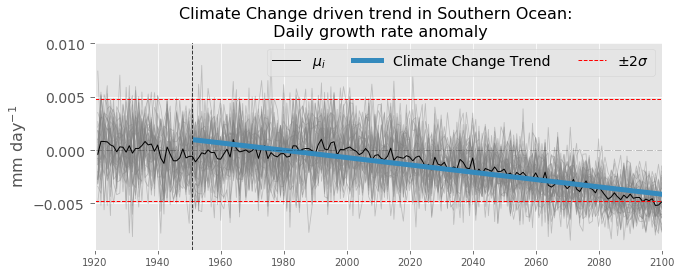

In [7]:
v = 'KGP'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_k, bf_k, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma

ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma

#ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(kgp_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

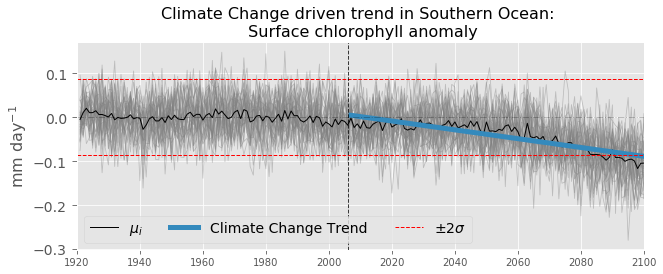

In [8]:
v = 'Chl_surf'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_c, bf_c, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(chl_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

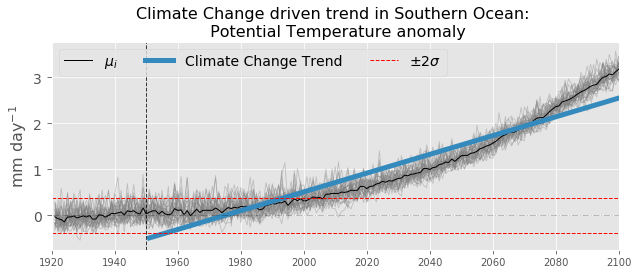

In [9]:
v = 'SST'
###########   As a Plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~    CESM-LE Anomalies   ~~~~~~~~~
for m_id in ds_djf.member_id:  # plots all ensemble members
    var_i = ds_djf[v].sel(member_id=m_id)
    ref_i = ds_djf[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf.time, anom, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ax.plot(ds_djf.time, anom_f[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean
#~~~~~~~~~~~~~~ Plot Best Fit of Climate Change~~~~~~
ax.plot(x_t, bf_t, color = 'C1', linewidth = 5, label = 'Climate Change Trend') # full time series
#~~~~~~~~~~~ Plot 2 Sigma ~~~~~~~~~~
ref = ds_djf[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])

ax.axhline((ds_ref_mean[v]-ref) + 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--') # positive two sigma
ax.axhline((ds_ref_mean[v]-ref) - 2 * ds_ref_std[v], 
           lw=1, color='r', linestyle='--', label = '$\pm2\sigma$') # negative two sigma
# ax.plot(ds_toe[v], ds_2sigma[v].sel(time=ds_toe[v])-ref, 'r*', color= 'purple', markersize=15)
#~~~~~~~~~~~~~~ add reference lines ~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.axvline(sst_yr, lw=1, color='k', linestyle='--', alpha = .75)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'Climate Change driven trend in {region}: \n {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

___
# Write a compact ToE function

In [46]:
def assess_toe(da):
    """ compute toe on the basis of henson et al 2017
    
    To calculate the ToE, ﬁrst the time series of annual extrema in the conjoined historical
    and warming scenario runs is created. Then, an inﬂection point is located by calculating
    the cumulative sum of the gradient in Yt (qY/qt) and identifying the year when it
    exceeds zero (for a positive trend) or drops below zero (for a negative trend) for the
    remainder of the time series—we refer to this as the start of the climate change signal
    The trend in Yt is then calculated from that start point forward to 2100 using numpy's polyfit function.
    
    The natural variability (or noise) is deﬁned as one standard deviation in annual extrema 
    of a 100-year section of the model’s control run. As a consequence, the natural variability 
    as deﬁned here accounts for only the unforced natural variability,
    excluding the inﬂuence of changing incoming solar radiation or volcanoes.
    The ToE is then deﬁned as: ToE = (2 σ) / slope
    """
    # compute anomalies
    da_ref = da.sel(time=slice(1920, 1950)).mean(['time', 'member_id']).values
    da_ref_std = da.sel(time=slice(1920, 1950)).std(['time', 'member_id']).values
    anom = da.mean('member_id') - da_ref

    # Calculate cumulative integral
    time = da.time.values
    anom_cumtrapz = integrate.cumtrapz(anom.values, time, initial=0)
    
    # creates a boolean array where values of the anomaly @ the 'end' of the time series 
    # that are greater than zero are assigned a 1 and less than zero are assigned a -1 everywhere else
    int_sign = np.where(anom.isel(time=-1).values > 0, 1, -1)

    # find the inflection point
    int_thresh = anom_cumtrapz * int_sign 
    
    ndx = None
    for l in range (len(time)):
           if all (int_thresh[l:] > 0):
        #if all (np.abs(int_thresh[l:]) > 0):
            ndx = l
            break #once it finds the year where the trend declines, break, then...
    # compute trend year and slope after inflection point
    if ndx is None:
        return tuple(np.nan for i in range(5))
    cc_yr = time[ndx]

    beta = np.polyfit(time[ndx:], anom[ndx:], 1)
    cc_slope = beta[0]
    cc_intercept = beta[1]

    # compute time of emergence: ToE = (2 σ) / slope
    toe = np.abs((2 * da_ref_std) / cc_slope)
    # calculate year of ToE (as an integral)
    toe_yr = int(cc_yr + toe)
    
    return time[ndx], cc_slope, cc_intercept, toe_yr,  toe

#### test across variables:

In [47]:
print(' Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)')
region = 'Southern Ocean'
print('KGP:', np.round(assess_toe(ds.KGP.sel(region=region).compute())))
print('Chl:', assess_toe(ds.Chl_surf.sel(region=region).compute()))
print('SST:', np.round(assess_toe(ds.SST.sel(region=region).compute())))

print('\n Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)')
region = 'AP Sector'
print('KGP:', np.round(assess_toe(ds.KGP.sel(region=region).compute())))
print('Chl:', assess_toe(ds.Chl_surf.sel(region=region).compute()))
print('SST:', np.round(assess_toe(ds.SST.sel(region=region).compute())))

print('\n Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)')
region = 'SW Atlantic'
print('KGP:', np.round(assess_toe(ds.KGP.sel(region=region).compute())))
print('SST:', np.round(assess_toe(ds.SST.sel(region=region).compute())))
print('Chl:', np.round(assess_toe(ds.Chl_surf.sel(region=region).compute())))


 Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)
KGP: [1951.   -0.    0. 2095.  144.]
Chl: (2006, -0.0009898208422373044, 1.9902113414289535, 2095, 89.77146824538589)
SST: [1950.    0.  -40. 1969.   20.]

 Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)
KGP: [1951.   -0.    0. 2095.  144.]
Chl: (2006, -0.0009898208422373044, 1.9902113414289535, 2095, 89.77146824538589)
SST: [1950.    0.  -40. 1969.   20.]

 Calculated Values (start of climate change, slope of climate change trend, intercept, year of toe, time of emergence)
KGP: [2033.   -0.    0. 2090.   58.]
SST: [1951.    0.  -40. 1969.   19.]
Chl: [nan nan nan nan nan]


## Visually Test Function

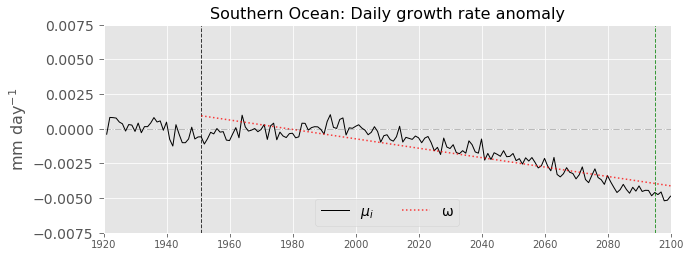

In [29]:
# ♫ ♩ Choose your character ♩ ♫
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin, limYMax = -0.0075, 0.0075
region= 'Southern Ocean'
ds_plot = ds.sel(region = region)

###########   Set up a plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

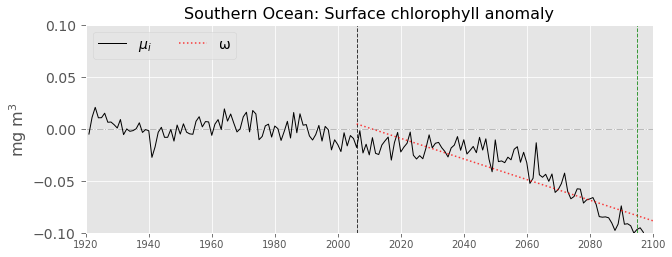

In [30]:
# ♫ ♩ Choose your character ♩ ♫
v = 'Chl_surf'
unit = 'mg m$^3$'
limYMin, limYMax = -0.1, 0.1
region= 'Southern Ocean'
ds_plot = ds.sel(region = region)

###########   Set up a plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

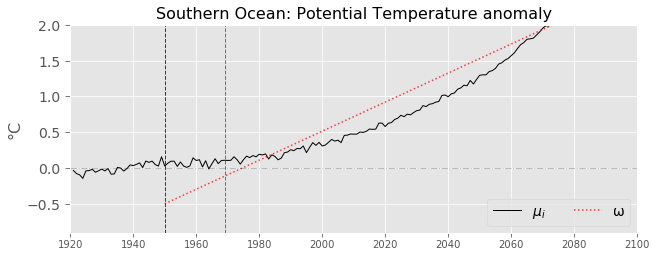

In [31]:
# ♫ ♩ Choose your character ♩ ♫
v = 'SST'
unit = '°C'
region= 'Southern Ocean'
ds_plot = ds.sel(region = region)
limYMin, limYMax = -0.9, 2
###########   Set up a plot  ##############
gs = gridspec.GridSpec(2,1)
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))

#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

# Plot all three

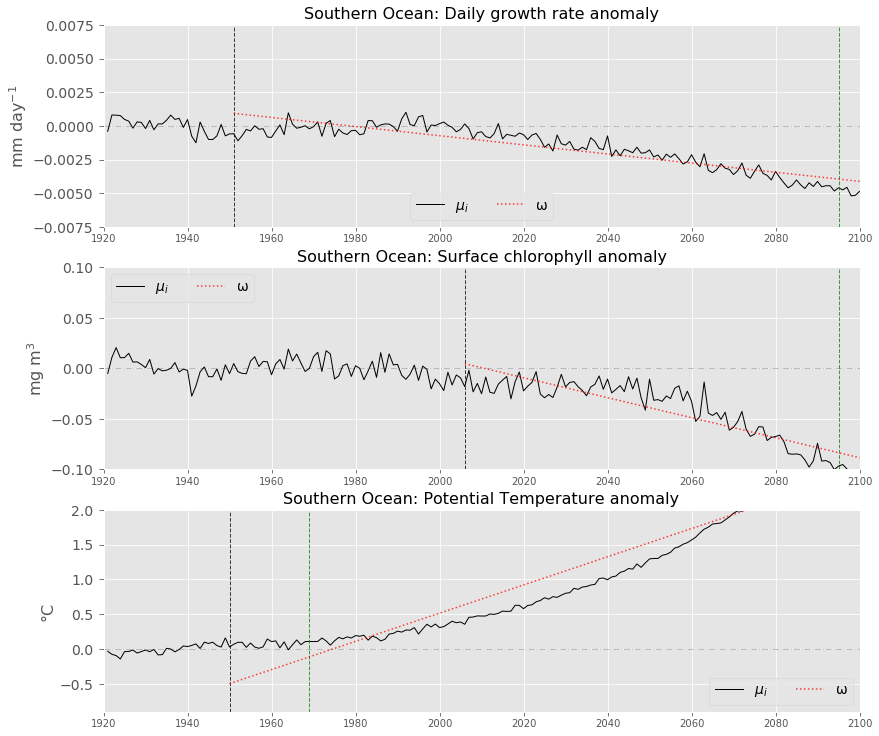

In [32]:
region= 'Southern Ocean'
ds_plot = ds.sel(region = region)

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(12,12))
###########   subplot 1  ##############
ax = fig.add_subplot(gs[0, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin, limYMax = -0.0075, 0.0075
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 2  ##############
ax = fig.add_subplot(gs[1, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'Chl_surf'
unit = 'mg m$^3$'
limYMin, limYMax = -0.1, 0.1
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 3  ##############
ax = fig.add_subplot(gs[2, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'SST'
unit = '°C'
limYMin, limYMax = -0.9, 2
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)


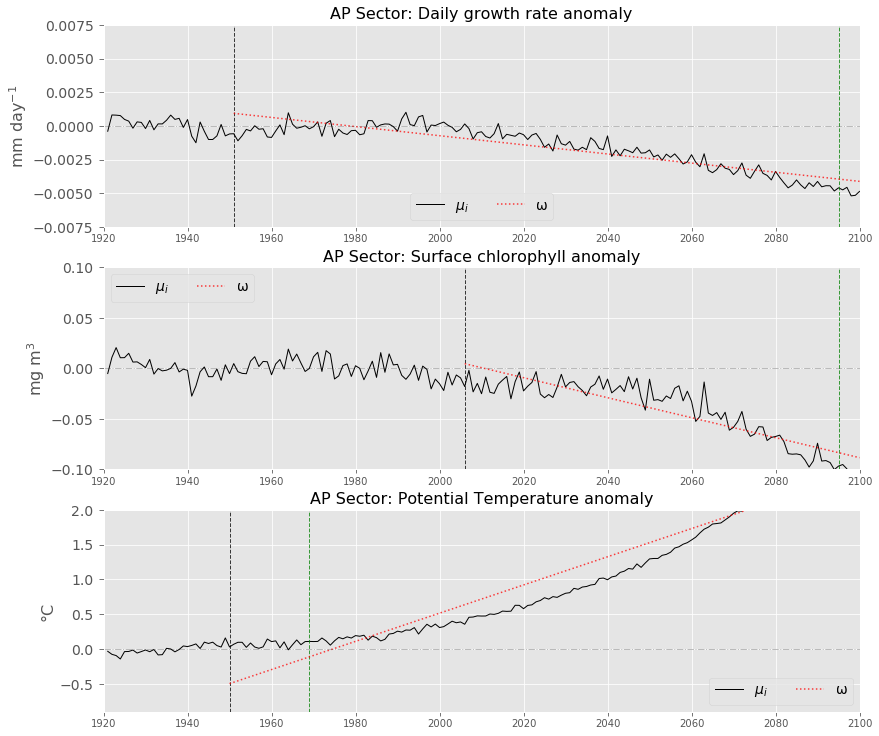

In [33]:
region= 'AP Sector'
ds_plot = ds.sel(region = region)

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(12,12))
###########   subplot 1  ##############
ax = fig.add_subplot(gs[0, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin, limYMax = -0.0075, 0.0075
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 2  ##############
ax = fig.add_subplot(gs[1, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'Chl_surf'
unit = 'mg m$^3$'
limYMin, limYMax = -0.1, 0.1
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 3  ##############
ax = fig.add_subplot(gs[2, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'SST'
unit = '°C'
limYMin, limYMax = -0.9, 2
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)


## Still not working where out of bounds (Atlantic Quadrant and SW Atlantic)

UnboundLocalError: local variable 'ndx' referenced before assignment

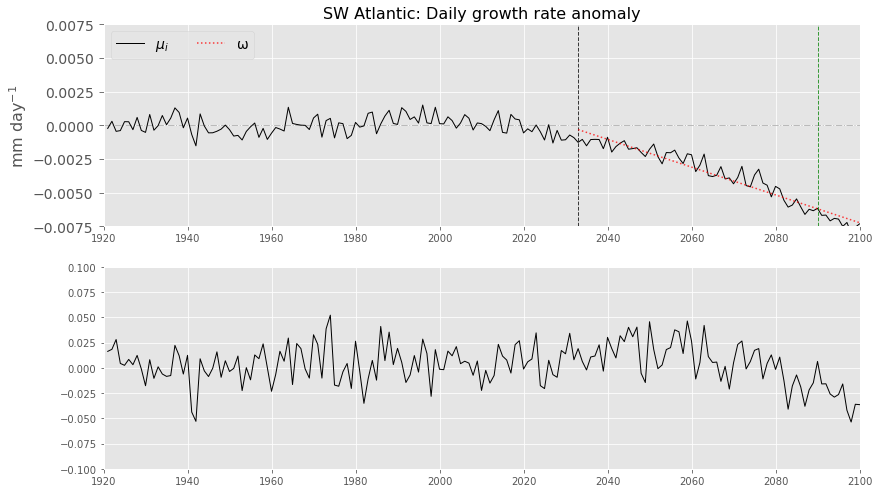

In [34]:
region= 'SW Atlantic'
ds_plot = ds.sel(region = region)

gs = gridspec.GridSpec(3,1)
fig = plt.figure(figsize=(12,12))
###########   subplot 1  ##############
ax = fig.add_subplot(gs[0, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin, limYMax = -0.0075, 0.0075
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 2  ##############
ax = fig.add_subplot(gs[1, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'Chl_surf'
unit = 'mg m$^3$'
limYMin, limYMax = -0.1, 0.1
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)

###########   subplot 3  ##############
ax = fig.add_subplot(gs[2, 0])
# ♫ ♩ Choose your character ♩ ♫
v = 'SST'
unit = '°C'
limYMin, limYMax = -0.9, 2
ax.set_xlim((1920, 2100))
ax.set_ylim((limYMin, limYMax))
#~~~~~~~~~~~~   Plot   ~~~~~~~~~~~~~~~~~~
# plot ensemble mean
mean_anom = ds_plot.mean('member_id') - ds_plot.sel(time=slice(1920, 1950)).mean(dim=['time', 'member_id']).compute()
ax.plot(ds_plot.time, mean_anom[v],'-', linewidth=1, color='k', label = '$\mu_i$') # ensemble mean

# calculate and plot reference lines: start of climate change and toe
cc_year = assess_toe(ds[v].sel(region=region).compute())[0]
cc_slope = assess_toe(ds[v].sel(region=region).compute())[1]
cc_int = assess_toe(ds[v].sel(region=region).compute())[2]
toe_yr = assess_toe(ds[v].sel(region=region).compute())[3]
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Calculate and Plot Best Fit of Climate Change
# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_plot.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_plot.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~ Finess the plot details ~~~~~~~~~~~~~~~~
ax.axhline(0, lw=1, color='k', linestyle='-.', alpha = .25)
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);
ax.legend(ncol = 3, fontsize = 14)
gs.update(hspace=.2, top=.92, right=1)
